# Data Preprocessing

Extract the about product from tht html bdy

In [ ]:
def extractAboutProduct(htmlBody):
  soup = BeautifulSoup(htmlBody, 'html.parser')
  if soup != None:
    # Extract the product description
    aboutProduct = ''
    if soup.find('span') != None:
      aboutProduct = soup.find('span').text.strip()
    elif soup.find('meta') != None:
      aboutProduct = soup.find('meta').text.strip()

    if soup.find('ul') != None:
      # Extract the list of product features
      for feature in soup.find('ul').find_all('li'):
          aboutProduct += feature.text.strip()

    return aboutProduct


Preprocess Extracted About Data

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

def preprocessText(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    text = ' '.join(filtered_text)
    return text

p c tote bag made sturdy denim hold weekly groceries lighter cargo ease printed flipped version brand initials internal pocket keep wallet keys phone within easy reach dark blue white denimtwo top handles designer embleminternal pocketthis bag capacity approximately 20 litres


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import pandas as pd

def jsonToDataFrame(storeLink):

  # create an empty dataframe with column names
  df = pd.DataFrame(columns=['ID', 'Title', 'About Product', 'Vendor', 'Product type', 'Product Link'])

  products_dict = {}
  page_number = 1
  productNumber = 0

  while True:
      # Make an HTTP GET request to the product data JSON endpoint
      response = requests.get(storeLink + '/collections/all/products.json?page=' + str(page_number))

      # If there are no more products, break out of the loop
      if len(response.json()['products']) == 0:
          break

      for product in response.json()['products']:
        productToBeAdded = [product['id'], product['title'], preprocessText(extractAboutProduct(product['body_html'])) + ' '.join(product['tags']), product['vendor'], product['product_type'], storeLink+'products/' + product['handle']]
        df.loc[productNumber] = productToBeAdded
        productNumber += 1
      
      page_number += 1
  return df
df = jsonToDataFrame('https://www.boysnextdoor-apparel.co/')


In [ ]:
df

,ID,Title,About Product,Vendor,Product type,Product Link
0,5751418519702,A.P.C. Daniela Logo-Print Denim Tote Bag,p c tote bag made sturdy denim hold weekly gro...,APC,Bag,https://www.boysnextdoor-apparel.co/products/a...
1,7728812490978,and Wander Dyneema Stuffsack,lightweight durable stuff sack wander produced...,and Wander,Bag,https://www.boysnextdoor-apparel.co/products/a...
2,7696930504930,and Wander Heather Waist Bag Charcoal,light sturdy waist bag japanese outdoor brand ...,and Wander,Bag,https://www.boysnextdoor-apparel.co/products/a...
3,7696940531938,and Wander Heather Waist Bag Navy,light sturdy waist bag japanese outdoor brand ...,and Wander,Bag,https://www.boysnextdoor-apparel.co/products/a...
4,7767737467106,Axel Arigato Marathon Sneaker White Silver,marathon sneakers frommesh uppersleather overl...,Axel Arigato,Shoes,https://www.boysnextdoor-apparel.co/products/a...
...,...,...,...,...,...,...
665,7728767860962,Wood Wood Low Profile Mondana Cap,inspired lifestyle atmosphere italian province...,Wood Wood,Cap,https://www.boysnextdoor-apparel.co/products/w...
666,7693151174882,WYM Heavy Weight Basic Big-Tee Beige,machine wash according instructions care label...,WYM,T-Shirt,https://www.boysnextdoor-apparel.co/products/w...
667,7693155107042,WYM Heavy Weight Basic Big-Tee Blue,machine wash according instructions care label...,WYM,T-Shirt,https://www.boysnextdoor-apparel.co/products/w...
668,7693148520674,WYM Heavy Weight Basic Big-Tee Grey,machine wash according instructions care label...,WYM,T-Shirt,https://www.boysnextdoor-apparel.co/products/w...


# Model building and training

Now that data is preprocessd I can build the model to classify the products. I have used unsupervised learning algorithm which is Kmeans.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

def classifierModel(df):
  # Create a vectorizer
  vectorizer = TfidfVectorizer(stop_words='english')

  # Vectorize the 'About Product' column  
  X = vectorizer.fit_transform(df['About Product'])

  # Set the number of clusters to 3 
  k = 10

  # Train the KMeans model
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(X)

  # Get the labels for each data point
  labels = kmeans.predict(X)

  # Add the labels to the DataFrame
  df['Cluster'] = labels

  # Group the rows by cluster label and extract the 'About Product' column into a list for each cluster
  clusters = df.groupby('Cluster')['Product Link'].apply(list).tolist()

  # Print the list of clusters
  return clusters

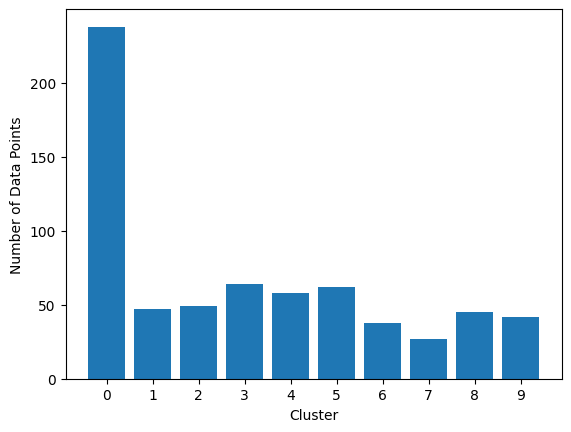

In [ ]:
import matplotlib.pyplot as plt

# Count the number of data points in each cluster
cluster_counts = df['Cluster'].value_counts()

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(cluster_counts.index, cluster_counts.values)
ax.set_xticks(cluster_counts.index)
ax.set_xlabel('Cluster')
ax.set_ylabel('Number of Data Points')
plt.show()


# Final Function to find alternative groups

In [ ]:
def FindAlternateGroups(storeLink):
  df = jsonToDataFrame(storeLink)
  arrayOfLinks = classifierModel(df)

  jsonDict = {}
  cluster_count = 1
  for array in arrayOfLinks:
    jsonDict['product alternates ' + str(cluster_count)] = array
    cluster_count += 1
  return jsonDict

https://www.boysnextdoor-apparel.co/

In [ ]:
FindAlternateGroups("https://www.boysnextdoor-apparel.co/")

https://www.woolsboutiqueuomo.com/

In [ ]:
FindAlternateGroups("https://www.woolsboutiqueuomo.com/")

https://sartale2022.myshopify.com/

In [ ]:
FindAlternateGroups("https://sartale2022.myshopify.com/")

https://glamaroustitijewels.com/

In [ ]:
FindAlternateGroups("https://glamaroustitijewels.com/")